## LSTM Model

In [1]:
import glob
import pandas as pd
import numpy as np
from numpy import concatenate
from numpy import sqrt
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    
    return df_data

In [3]:
fpath = "..\\data\\all_raw_files"
model_data_file = "model_data.csv"
model_data = read_data(f'{fpath}\{model_data_file}')

In [4]:
model_data

,year,month,date,temp_mean,temp_min,temp_max,temp_avg_daily_min,temp_avg_daily_max,degree_days,demand_mean,demand_max,demand_avg_daily_max,total_consumption,pv_capacity,population,gsp
0,2010,1,2010-01-01,20.868008,1.6,41.1,16.380645,25.858065,144.511358,8941.450389,13765.04,10613.530000,6554083.135,28278.392,7110454,44504.250000
1,2010,2,2010-02-01,20.218907,3.2,35.4,16.146429,24.682143,124.982743,8855.467677,13377.27,10380.667857,5831325.465,32153.986,7119405,44504.250000
2,2010,3,2010-03-01,19.828286,6.3,34.7,15.496774,24.725806,106.809763,8698.725127,11991.47,10132.978710,6319623.805,38195.588,7128356,44504.250000
3,2010,4,2010-04-01,17.593856,6.5,29.9,12.780000,23.063333,68.136038,8452.863411,11436.13,9804.072333,5984627.295,45142.723,7133668,44504.250000
4,2010,5,2010-05-01,15.323485,3.1,28.4,11.187097,19.596774,123.937772,8897.770510,12386.49,10558.023548,6459781.390,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,2021-08-01,21.104167,16.9,30.7,17.766667,24.966667,9.312500,7368.353056,9043.62,8410.176667,530521.420,3954209.744,8091356,57391.083333
140,2021,9,2021-09-01,20.999306,14.2,27.5,15.433333,25.300000,8.997917,7229.393819,9206.19,8469.680000,520516.355,4033918.477,8088503,57391.083333
141,2021,10,2021-10-01,21.084722,14.8,26.9,16.300000,25.466667,9.254167,7209.823194,8841.21,8575.093333,519107.270,4112353.036,8092743,57391.083333
142,2021,11,2021-11-01,22.118056,15.7,27.3,16.466667,26.566667,12.354167,7649.492569,9573.70,9336.970000,550763.465,4192992.282,8096983,57391.083333


## Decision on data to test, Temp_mean , pv_capacity, population ~ demand_mean_max

In [5]:
model_data_new = model_data[["degree_days", "pv_capacity", "population", "demand_avg_daily_max"]]
model_data_arr = model_data_new.values
model_data_arr
#Scale the model array
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(model_data_arr)
model_data_arr = scaler.transform(model_data_arr)
# Split training and testing data, testing data is last 24 months
model_data_x = model_data_arr[: , 0:-1]
model_data_y =  model_data_arr[: , -1]
lstm_train_x, lstm_test_x = model_data_x[0:-24 ], model_data_x[-24: ]
lstm_train_y, lstm_test_y  = model_data_y[0:-24 ], model_data_y[-24: ]

# reshape input to be 3D [samples, timesteps, features]
lstm_train_x = lstm_train_x.reshape((lstm_train_x.shape[0], 1, lstm_train_x.shape[1]))
lstm_test_x = lstm_test_x.reshape((lstm_test_x.shape[0], 1, lstm_test_x.shape[1]))
print(lstm_train_x.shape, lstm_train_y.shape, lstm_test_x.shape, lstm_test_y.shape)

(120, 1, 3) (120,) (24, 1, 3) (24,)


In [6]:
lstm_train_x

array([[[ 0.47860436, -1.        , -1.        ]],

       [[ 0.26604799, -0.99818183, -0.98212565]],

       [[ 0.06824685, -0.99534751, -0.9642513 ]],

       [[-0.35269165, -0.99208838, -0.95364371]],

       [[ 0.25467417, -0.9877594 , -0.94303612]],

       [[ 0.85983324, -0.98152703, -0.93242853]],

       [[ 0.80001737, -0.97457749, -0.92015951]],

       [[ 0.64142367, -0.96677098, -0.9078885 ]],

       [[ 0.17961415, -0.95802332, -0.89561748]],

       [[-0.08336674, -0.94818275, -0.88419315]],

       [[-0.12537975, -0.93692419, -0.87276683]],

       [[ 0.14918553, -0.92927149, -0.86134051]],

       [[ 0.74263085, -0.91638216, -0.84480209]],

       [[ 0.1955102 , -0.90411922, -0.82826368]],

       [[ 0.03201814, -0.89067583, -0.81172526]],

       [[-0.42143774, -0.8795281 , -0.80254546]],

       [[ 0.4750398 , -0.86628497, -0.79336566]],

       [[ 0.57636892, -0.85140791, -0.78418387]],

       [[ 0.86648526, -0.84910329, -0.77020749]],

       [[ 0.47521542, -0.847090



Epoch 1/50

1/1 - 3s - loss: 0.1471 - val_loss: 0.2665 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.1450 - val_loss: 0.2641 - 60ms/epoch - 60ms/step
Epoch 3/50
1/1 - 0s - loss: 0.1429 - val_loss: 0.2617 - 45ms/epoch - 45ms/step
Epoch 4/50
1/1 - 0s - loss: 0.1410 - val_loss: 0.2594 - 35ms/epoch - 35ms/step
Epoch 5/50
1/1 - 0s - loss: 0.1392 - val_loss: 0.2570 - 46ms/epoch - 46ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1375 - val_loss: 0.2546 - 44ms/epoch - 44ms/step
Epoch 7/50
1/1 - 0s - loss: 0.1359 - val_loss: 0.2523 - 39ms/epoch - 39ms/step
Epoch 8/50
1/1 - 0s - loss: 0.1343 - val_loss: 0.2499 - 42ms/epoch - 42ms/step
Epoch 9/50
1/1 - 0s - loss: 0.1329 - val_loss: 0.2474 - 48ms/epoch - 48ms/step
Epoch 10/50
1/1 - 0s - loss: 0.1316 - val_loss: 0.2450 - 42ms/epoch - 42ms/step
Epoch 11/50
1/1 - 0s - loss: 0.1303 - val_loss: 0.2424 - 45ms/epoch - 45ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1291 - val_loss: 0.2398 - 36ms/epoch - 36ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1279 - val_loss: 0.

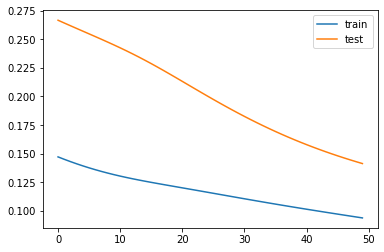

In [7]:
# Run model
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(lstm_train_x, lstm_train_y, epochs=50, batch_size=124, validation_data=(lstm_test_x, lstm_test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

1/1 [==============================] - 0s 28ms/step


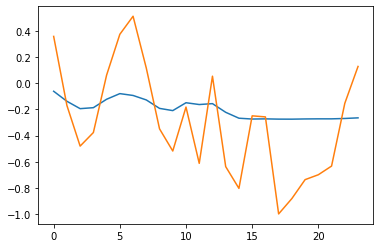

In [11]:
yhat = model.predict(lstm_test_x)
plt.plot(yhat)
plt.plot(lstm_test_y)

In [8]:
# make a prediction
lstm_test_sx = lstm_test_x.reshape((lstm_test_x.shape[0], lstm_test_x.shape[2]))
# invert scaling for forecast
inv_xyhat = concatenate((lstm_test_sx, yhat), axis=1)
inv_yyhat = scaler.inverse_transform(inv_xyhat)
inv_yhat = inv_yyhat[:,3]
# invert scaling for actual
lstm_test_sy = lstm_test_y.reshape((len(lstm_test_y), 1))
inv_sy = concatenate((lstm_test_sy, lstm_test_sy), axis=1)
inv_ty = concatenate((inv_sy, inv_sy), axis=1)
inv_wy = scaler.inverse_transform(inv_ty)
inv_y = inv_wy[:,3]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


1/1 [==============================] - 0s 420ms/step
Test RMSE: 596.075


In [9]:
inv_y

array([10149.83354839,  9311.35896552,  8817.48580645,  8982.185     ,
        9679.50612903, 10175.359     , 10394.69774194,  9764.8       ,
        9027.053     ,  8757.94032258,  9291.63633333,  8608.12129032,
        9666.57      ,  8568.18421053,  8304.00666667,  9185.06666667,
        9172.25      ,  7993.9       ,  8180.34      ,  8410.17666667,
        8469.68      ,  8575.09333333,  9336.97      ,  9784.83333333])

In [10]:
inv_yhat

array([9483.47949391, 9361.9571684 , 9272.33528171, 9284.23926797,
       9386.42872399, 9454.91100936, 9432.54458172, 9378.1680989 ,
       9275.61897455, 9248.64403952, 9344.22541143, 9322.40547024,
       9333.2770822 , 9228.01011986, 9156.29063052, 9146.27777454,
       9148.21149399, 9145.1249357 , 9144.69299338, 9147.32945813,
       9148.63596784, 9148.51902483, 9153.1194138 , 9160.56741727])